# Chatbot with Collection Schema 

## Review

We built a chatbot that saves memories to the [store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) using a single profile schema.
 
We used [Trustcall](https://github.com/hinthornw/trustcall) to update the profile schema. 

## Goals

But, our chatbot still has a few shortcomings: 

Second, it wrote based upon a user-provided keyword (`remember`). In practice, we often want the chatbot to decide when to save a memory rather than relying on the user to explicitly tell it. 


It only wrote based upon a user-provided keyword (`remember`). 

Here, we'll add a tool that allows that chatbot to decide when to save memories! 

We'll also show how to use [Trustcall](https://github.com/hinthornw/trustcall) to update a collection of memories, rather than a single schema. 


In [ ]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall

In [1]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Defining a memory schema

Recall that the [LangGraph Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) supports any schema for the `value` part of the key-value pair. 

This allows you to store structured information. We just showed how to store a single single schema that will be updated with new information via [Trustcall](https://github.com/hinthornw/trustcall) the chatbot interacts with the user.

As we discussed in the first lesson of this module, there are trade-offs with a single profile versus a collection of memories. 

Here, we'll store a collection and use [Trustcall](https://github.com/hinthornw/trustcall) to update the collection, enabling both addition of new memories as well as updating existing memories in the collection.

First, let's define a memory schema. 

In [15]:
# Pydantic Schema

from pydantic import BaseModel, Field
class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")
    context: str = Field(description="Additional context for the memory. For example: This was mentioned while discussing career options in Europe.")

In [3]:
_set_env("OPENAI_API_KEY")

In [16]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Bind Memory schema as a tool to the model
model_with_tools = model.bind_tools([Memory])

# Invoke the model with personal information, which should trigger the tool call
output = model_with_tools.invoke([HumanMessage("My name is Lance, I like to bike.")])
output.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_TG6g3uvs4Z8NtaljNavGCf7e)
 Call ID: call_TG6g3uvs4Z8NtaljNavGCf7e
  Args:
    content: User's name is Lance and he likes to bike.
    context: User shared personal interests.


We can *also* use Trustcall to manage a collection of memories. 

In [7]:
from trustcall import create_extractor

conversation = """User: Hi, I'm Lance.
Assistant: Nice to meet you, Lance.
User: I really like biking around San Francisco."""

trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    # This allows the extractor to insert new memories
    enable_inserts=True,
)

# Instruction
instruction = f"""Extract memories from the following conversation:
<convo>
{conversation}
</convo>"""

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [HumanMessage(content=instruction)]})
memories = result["responses"]
memories

[Memory(content='User likes biking around San Francisco.', context='User introduced themselves as Lance.')]

In [11]:
memories[0].model_dump(mode="json")

{'content': 'User likes biking around San Francisco.',
 'context': 'User introduced themselves as Lance.'}

In [ ]:
https://github.com/hinthornw/trustcall?tab=readme-ov-file#simultanous-updates--insertions

In [14]:
# Update the conversation
updated_conversation = """User: Hi, I'm Lance.
Assistant: Nice to meet you, Lance.
User: I really like biking around San Francisco.
Assistant: San Francisco is a great city! Where do you go after biking?
User: I really like to go to a bakery."""

# Update the instruction
updated_instruction = f"""Reflect on following interaction. Use the provided tools to retain any necessary memories about the user. 
Use parallel tool calling to handle updates & insertions simultaneously:
<convo>
{updated_conversation}
</convo>"""

existing_memories = [(str(i), "Memory", memory.model_dump()) for i, memory in enumerate(memories)] if memories else None

# Invoke the extractor with the updated instruction and existing profile with the corresponding tool name (UserProfile)
result = trustcall_extractor.invoke({"messages": [HumanMessage(content=updated_instruction)], 
                                     "existing": existing_memories})

updated_memories = result["responses"]
updated_memories

[Memory(content='User likes biking around San Francisco and going to a bakery afterwards.', context='User introduced themselves as Lance.'),
 Memory(content='User likes to go to a bakery after biking.', context='This was mentioned in a conversation about biking in San Francisco.')]

## WIP (Add Trustcall as introduced above): Managing a memory collection with our chatbot 

Now, we can bring this all together and improve our chatbot in a few ways: 

First, it will decide when to save memories.

Second, it will extract the structured information from the message(s) into the specified memory schema.

Third, it will save the memories as a collection, updating the existing collection as we learn more about the user.

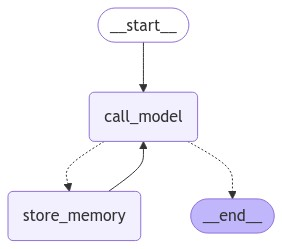

In [16]:
from IPython.display import Image, display

from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Call the model with the system prompt that contains the memories as well as the user's messages."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Retrieve the most recent memories for context
    memories = store.search(namespace)

    # Format the memories for the system prompt
    info = "\n".join(f"[{mem.key}]: {mem.value}" for mem in memories)
    system_msg = f"""You are a helpful assistant talking to the user.  
    Save any relevant information as a memory.
    Here are existing memories: {info}"""

    # Invoke the model with the system prompt that contains the memories as well as the user's messages
    response = model_with_tools.invoke([SystemMessage(content=system_msg)]+state["messages"])
    return {"messages": response}

def store_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Store the tool calls in the memory store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Generate a unique key for each memory
    key = str(uuid.uuid4())

    # Extract tool calls from the last message
    tool_calls = state['messages'][-1].tool_calls

    # Save each produced tool call schema to the store
    for tc in tool_calls:
        in_memory_store.put(namespace, key, tc["args"])

    # Create tool messages to confirm to the model that the tool calls were successful
    results = [
        ToolMessage(content=tc["args"], tool_call_id=tc["id"])
        for tc in tool_calls
    ]
    return {"messages": results}

def route_message(state: MessagesState):
    
    """Determine the next step based on the presence of tool calls."""

    # Get the last message from the user
    msg = state['messages'][-1]

    # If there are tool calls, we need to store memories
    if msg.tool_calls:
        return "store_memory"
    
    # Otherwise, finish; user can send the next message
    return END

# Define the graph
builder = StateGraph(MessagesState)

# Define the flow of the memory extraction process
builder.add_node(call_model)
builder.add_edge(START, "call_model")
builder.add_node(store_memory)
builder.add_conditional_edges("call_model", route_message, ["store_memory", END])
builder.add_edge("store_memory", "call_model")

# Store from cross-thread memory
in_memory_store = InMemoryStore()

# We compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=MemorySaver(), store=in_memory_store)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [17]:
# We supply a user ID for across-thread memory as well as a thread ID for within-thread memory
config = {"configurable": {"thread_id": "1", "user_id": "Lance"}}

# Chat with the chatbot
input_messages = [HumanMessage(content="Hi! My name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! My name is Lance
================================== Ai Message ==================================
Tool Calls:
  Memory (call_GNeh0QRN5QL1sQe9eofREqbO)
 Call ID: call_GNeh0QRN5QL1sQe9eofREqbO
  Args:
    content: User's name is Lance.
    context: User introduced themselves.
================================= Tool Message =================================

{'content': "User's name is Lance.", 'context': 'User introduced themselves.'}
================================== Ai Message ==================================

Hello, Lance! How can I assist you today?


In [18]:
# Chat with the chatbot
input_messages = [HumanMessage(content="I like to bike around San Francisco.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco.
================================== Ai Message ==================================
Tool Calls:
  Memory (call_v5vkLaUPVbSwmPSmbYUaHvpy)
 Call ID: call_v5vkLaUPVbSwmPSmbYUaHvpy
  Args:
    content: User likes to bike around San Francisco.
    context: User shared their interest in biking.
================================= Tool Message =================================

{'content': 'User likes to bike around San Francisco.', 'context': 'User shared their interest in biking.'}
================================== Ai Message ==================================

That's great, Lance! San Francisco is a beautiful place for biking. Do you have any favorite routes or spots you like to visit?


In [19]:
# Chat with the chatbot
input_messages = [HumanMessage(content="I also like to go to bakeries.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also like to go to bakeries.
================================== Ai Message ==================================
Tool Calls:
  Memory (call_zKUhF3DJCrkVdIyTW5xOdefX)
 Call ID: call_zKUhF3DJCrkVdIyTW5xOdefX
  Args:
    content: User likes to visit bakeries.
    context: User shared another interest.
================================= Tool Message =================================

{'content': 'User likes to visit bakeries.', 'context': 'User shared another interest.'}
================================== Ai Message ==================================

That sounds delicious! San Francisco has some amazing bakeries. Do you have a favorite bakery or a type of pastry you enjoy the most?


We can see that we're successfully adding memories to the collection as we learn more about the user!

This is saving a growing [collection](https://langchain-ai.github.io/langgraph/concepts/memory/#manage-a-collection-of-memories) of memories, because each memory has a unique key. 

In [20]:
# Namespace for the memory to save
user_id = "Lance"
namespace = ("memories", user_id)

# Search 
for memory in in_memory_store.search(namespace):
    print(memory.value)

{'content': "User's name is Lance.", 'context': 'User introduced themselves.'}
{'content': 'User likes to bike around San Francisco.', 'context': 'User shared their interest in biking.'}
{'content': 'User likes to visit bakeries.', 'context': 'User shared another interest.'}


Create a new thread, and chat with the chatbot again.

In [21]:
# We supply a user ID for across-thread memory as well as a thread ID for within-thread memory
config = {"configurable": {"thread_id": "2", "user_id": "Lance"}}

# Chat with the chatbot
input_messages = [HumanMessage(content="What bakeries would you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries would you recommend for me?
================================== Ai Message ==================================

Since you like to visit bakeries and you're in San Francisco, here are a few recommendations you might enjoy:

1. **Tartine Bakery** - Known for its delicious bread and pastries, Tartine is a must-visit for any bakery enthusiast.

2. **B. Patisserie** - Offers a delightful selection of French pastries, including their famous kouign-amann.

3. **Arizmendi Bakery** - A worker-owned cooperative bakery known for its fresh bread, pastries, and pizza.

4. **Craftsman and Wolves** - A contemporary patisserie with inventive pastries and a unique twist on classic items.

5. **Mr. Holmes Bakehouse** - Famous for their cruffins and a variety of other creative baked goods.

These bakeries offer a range of delicious options that should satisfy your bakery cravings!


Nice! It responds with personalization because it has access to my memories. 

We can confirm that it's a new thread and that none of the prior messages are saved.

So, the personalization is via the memories. 


In [22]:
thread = {"configurable": {"thread_id": "2"}}
state = graph.get_state(thread).values
for m in state["messages"]: 
    m.pretty_print()

================================ Human Message =================================

What bakeries would you recommend for me?
================================== Ai Message ==================================

Since you like to visit bakeries and you're in San Francisco, here are a few recommendations you might enjoy:

1. **Tartine Bakery** - Known for its delicious bread and pastries, Tartine is a must-visit for any bakery enthusiast.

2. **B. Patisserie** - Offers a delightful selection of French pastries, including their famous kouign-amann.

3. **Arizmendi Bakery** - A worker-owned cooperative bakery known for its fresh bread, pastries, and pizza.

4. **Craftsman and Wolves** - A contemporary patisserie with inventive pastries and a unique twist on classic items.

5. **Mr. Holmes Bakehouse** - Famous for their cruffins and a variety of other creative baked goods.

These bakeries offer a range of delicious options that should satisfy your bakery cravings!


## LangSmith Trace

We can also see the trace in LangSmith:

https://smith.langchain.com/public/cdc74964-0d74-4ed0-9e81-0a4fbdf5d030/r

## TODO: Add Studio 